# Modeling & Fitting

In [1]:
import os
import sys
sys.path.insert(0, "../../")

import mpld3
mpld3.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

from core import util, config, database
from core.data.model import ModelDataRepo
from core.data.model.entities import *

database.init()
ModelDataRepo.init_weights()
config.init_plot()

### Get Data

In [2]:
selected_kabko = "KOTA BLITAR"
kabko = ModelDataRepo.get_kabko_full(selected_kabko)

In [3]:
kabko._kapasitas_rs

[(0, 10), (70, 11)]

### Make Model

In [4]:
from core.modeling import SeicrdRlcModel

mod = SeicrdRlcModel(kabko)

### Select Datsets to Use for Fitting

In [5]:
used_datasets = [
    #"infectious", 
    "critical_cared", 
    "infectious_all", 
    "recovered", 
    "dead",
    #"infected"
]
mod.use_datasets(used_datasets)

### List Variables that Can be Fitted

In [6]:
varying_init = [
    "death_rate_over",
    "exposed_rate_over", 
    "kapasitas_rs_mul", 
    "test_coverage_max", 
    "test_coverage_0", "test_coverage_increase", 
    "infectious_rate", 
    "recovery_rate_normal", "recovery_rate_critical",
    "critical_rate", "critical_chance",
    "death_rate_normal", "death_chance_normal", 
    "k", "r_0", "r_1", "r_2"
]

### Select Variables to Fit

In [7]:
varying_now = [
    #"death_rate_over",
    #"exposed_rate_over", 
    #"kapasitas_rs_mul", 
    #"test_coverage_max", 
    #"test_coverage_0", "test_coverage_increase", 
    "infectious_rate", 
    "recovery_rate_normal", "recovery_rate_critical",
    "critical_rate", "critical_chance",
    "death_rate_normal", "death_chance_normal", 
    "k", "r_0", "r_1", "r_2"
]
unvary = [x for x in varying_init if x not in varying_now]

### Fit!

In [8]:
result = mod.fit(method="leastsq", test_splits=[3], unvary=unvary)
result.fit_result.message

### Fit Results

Params Should Have "standard error" and "relative error" Columns. If they dont:
1. A parameter might not be significant
2. A parameter has hit its min/max limit and can't vary

In [9]:
result.fit_result.params

name,value,standard error,relative error,initial value,min,max,vary
days,128.000000,0.00000000,(0.00%),128,-inf,inf,False
population,142798.000,0.00000000,(0.00%),142798,-inf,inf,False
infectious_rate,0.07142899,0.00714290,(10.00%),0.07142857621262555,0.07142857,0.33333333,True
critical_chance,0.13323785,0.01332378,(10.00%),0.2675717433590259,0.01000000,0.66666667,True
critical_rate,0.14285714,0.01428571,(10.00%),0.14285714285714285,0.08333333,0.14285714,True
recovery_rate_normal,0.05000000,0.00500000,(10.00%),0.050000000000000155,0.05000000,0.11111111,True
recovery_rate_critical,0.15384615,0.01538462,(10.00%),0.15384615384615385,0.05384615,0.15384615,True
death_chance_normal,0.24998590,0.02499859,(10.00%),0.24999999942227755,0.00500000,0.25000000,True
death_rate_normal,0.14725566,0.01472557,(10.00%),0.1,0.10000000,0.20000000,True
death_chance_over,1.00000000,0.00000000,(0.00%),1.0,-inf,inf,False


### Predict

In [14]:
values = dict(result.fit_result.values)
values["days"] += 30
values["days"]

158

In [15]:
model_result = mod.model(**values)

### Plot!

In [16]:
from core.modeling import ModelPlotter

plotter = ModelPlotter(model_result)

In [17]:
length = kabko.data_count + result.outbreak_shift
length

128

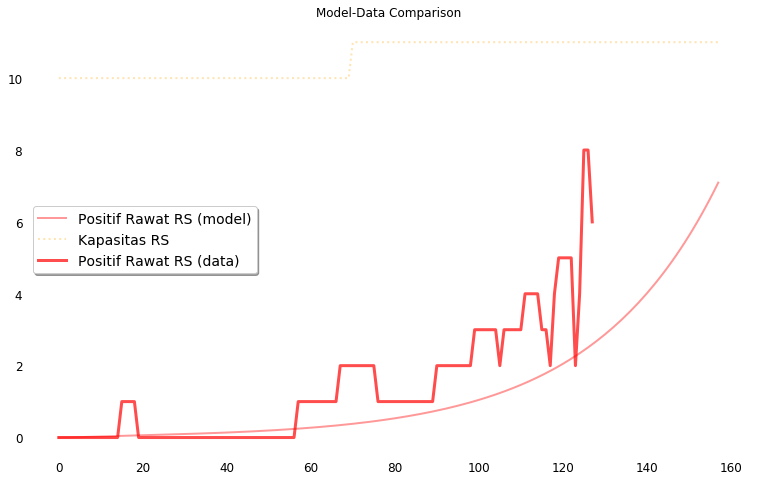

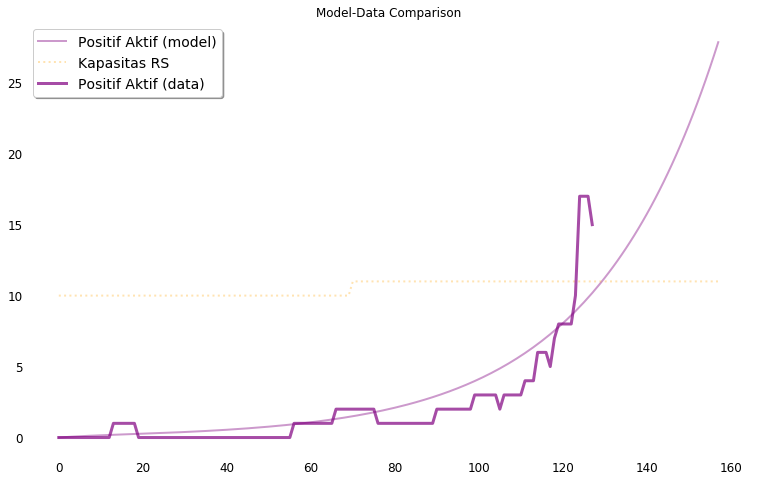

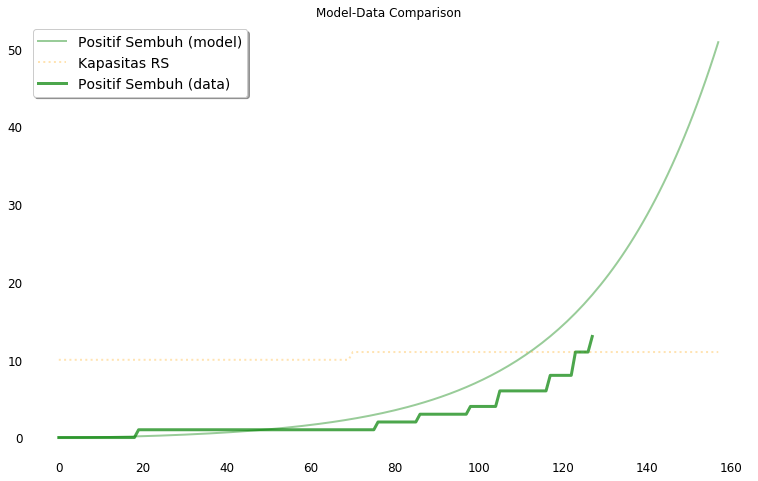

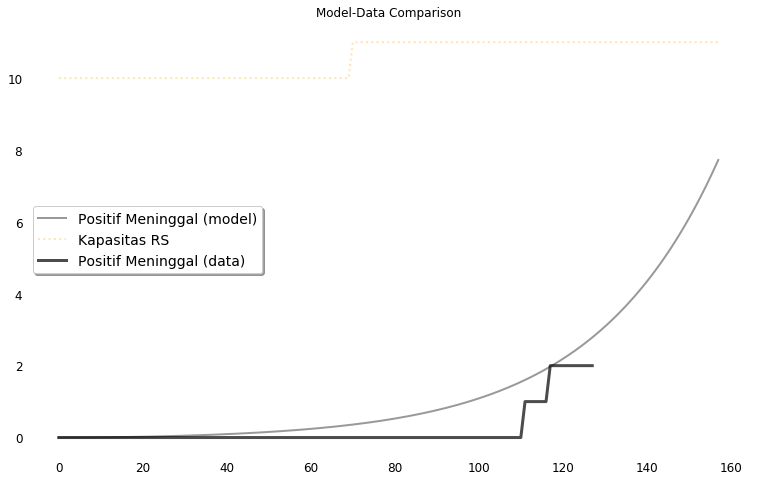

In [31]:
import matplotlib.pyplot as plt
for d in used_datasets:
    datasets = kabko.get_datasets([d], result.outbreak_shift)
    plotter.plot(
        plotter.plot_main_data, 
        datasets,
        length
    )
    plt.show()

plotter.plot(plotter.plot_main_lite);

plotter.plot(plotter.plot_daily_lite);

plotter.plot(plotter.plot_r0);

plotter.plot(plotter.plot_mortality_rate);

plotter.plot(plotter.plot_over);

plotter.plot(plotter.plot_dead);

plotter.plot(plotter.plot_healthcare);

### Model Scores

In [27]:
print("Last fit scores")
result.fit_scorer.report()
print()

Last fit scores
Varying Parameters: 8
Residual Mean (~0): [ 0.7662304  -0.39061844 -1.53790543 -0.38739369]
Residual Median (~0): [ 0.45591949 -0.47012248 -0.86862941 -0.23601879]
Max Error (~0): [5.57569418 7.79182176 7.46654075 1.54735268]
MAE (~0): [0.85530411 0.98394736 1.7734011  0.38781639]
MSE (~0): [1.7388912  2.52649433 6.91999036 0.31308851]
RMSE (~0): [1.31867024 1.58949499 2.63058746 0.55954313]
RMSLE (~0): [0.42264755 0.36884987 0.38980563 0.3693418 ]
Explained Variance: [0.5784663  0.78091126 0.41462102 0.52442452]
R2 (~1): [0.36359386 0.76682937 0.11065607 0.08660217]
Adjusted R2 (~1): [0.32081026 0.75115403 0.05086824 0.02519728]
SMAPE (~0): [0.66691622 0.52797124 0.39388683 0.87901072]
MASE (~0): [0.97445251 1.03119159 1.07068462 1.04692448]
Chi Square: [222.57807382127527, 323.3912737709951, 885.7587660849506, 40.075329692816375]
Reduced Chi Square: [1.8548172818439606, 2.694927281424959, 7.3813230507079215, 0.3339610807734698]
AIC: [86.81570172373617, 134.63458561096

In [29]:
print("Last fit scores flat")
result.fit_scorer.flatten().report()
print()

Last fit scores flat
Varying Parameters: 8
Residual Mean (~0): [-0.38742179]
Residual Median (~0): [-0.14821829]
Max Error (~0): [7.79182176]
MAE (~0): [1.00011724]
MSE (~0): [2.8746161]
RMSE (~0): [1.69546929]
RMSLE (~0): [0.38827921]
Explained Variance: [0.55601983]
R2 (~1): [0.53156067]
Adjusted R2 (~1): [0.52411034]
SMAPE (~0): [0.61694625]
MASE (~0): [0.97445251]
Chi Square: [1471.8034433700373]
Reduced Chi Square: [2.9202449273215025]
AIC: [556.6305971272084]
AICc: [556.9168794333714]
BIC: [590.5371941275245]
Durbin-Watson: [0.14134895]
Residual Normal Test Shapiro p (p>a): [1.9516232e-22]
Residual Runs Test p (p>0.5): [4.02009612e-89]
F-Test Overall Significance p (p<a): [0.00507706]
F-Test pred-data p (p>a): [0.02810816]
F-Test residual-zero p (p>a): [1.37547133e-07]
KS-Test pred-data p (p>a): [1.78257969e-46]
KS-Test residual-normal p (p>a): [3.09706517e-28]
Prediction Interval p (p<a): [0.9921875]



In [28]:
if result.test_scorer:
    print("Test scores")
    result.test_scorer.report()
    print()

Test scores
Varying Parameters: 8
Residual Mean (~0): [ 1.27417     1.43097955 -0.63526723 -0.10890977]
Residual Median (~0): [ 0.859979    0.70739928 -0.53011099 -0.00811486]
Max Error (~0): [ 6.3295747  13.26755889  2.4855701   1.11133833]
MAE (~0): [1.3467399  1.58504826 0.77783473 0.21844   ]
MSE (~0): [3.26264298 9.16580945 0.99363056 0.16756713]
RMSE (~0): [1.80627877 3.02750879 0.99681019 0.40934965]
RMSLE (~0): [0.63745301 0.54850015 0.22997034 0.26841964]
Explained Variance: [0.43882547 0.45134967 0.92954343 0.64268312]
R2 (~1): [-0.1169998   0.29351661  0.88135601  0.61546347]
Adjusted R2 (~1): [-0.21971243  0.22855262  0.87044622  0.58010379]
SMAPE (~0): [0.74075164 0.59543537 0.14194017 0.84476436]
MASE (~0): [0.98322978 0.99165358 1.04446792 1.01369014]
Chi Square: [313.2137265071376, 879.9177071787253, 95.38853379899746, 16.08644475378096]
Reduced Chi Square: [3.5592468921265636, 9.999064854303697, 1.0839606113522438, 0.18280050856569272]
AIC: [129.52360944060104, 228.686

In [30]:
if result.test_scorer:
    print("Test scores flat")
    result.test_scorer.flatten().report()
    print()

Test scores flat
Varying Parameters: 8
Residual Mean (~0): [0.49024314]
Residual Median (~0): [-0.00545467]
Max Error (~0): [13.26755889]
MAE (~0): [0.98201572]
MSE (~0): [3.39741253]
RMSE (~0): [1.84320713]
RMSLE (~0): [0.45610695]
Explained Variance: [0.57013825]
R2 (~1): [0.53741419]
Adjusted R2 (~1): [0.5275457]
SMAPE (~0): [0.58072288]
MASE (~0): [0.9791366]
Chi Square: [1304.6064122386413]
Reduced Chi Square: [3.4696979048900034]
AIC: [485.6374227948399]
AICc: [486.0214227948399]
BIC: [517.2425632155417]
Durbin-Watson: [0.223624]
Residual Normal Test Shapiro p (p>a): [4.45715872e-26]
Residual Runs Test p (p>0.5): [1.15862936e-74]
F-Test Overall Significance p (p<a): [2.54434359e-22]
F-Test pred-data p (p>a): [0.00595089]
F-Test residual-zero p (p>a): [8.91299789e-08]
KS-Test pred-data p (p>a): [2.73723365e-19]
KS-Test residual-normal p (p>a): [6.4023906e-11]
Prediction Interval p (p<a): [1.]



### Save Params

Run code below ONLY if you want to save the parameters.

In [32]:
ModelDataRepo.save_fitting_result(result)